### Visualizing what convnets learn
- Note: It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets. The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts.
- Three most accessible and useful techniques for visualizing and interpreting these representations:
 - Visualizing intermediate convnet outputs (intermediate activations)— Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
 - Visualizing convnets filters:— Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
 - Visualizing heatmaps of class activation in an image:— Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.

### Visualizing intermediate activations:

In [8]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
from keras import models
import matplotlib.pyplot as plt

In [12]:
model = load_model('cats_and_dogs_small_2.h5')

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### Processing a Single Image

In [14]:
img_path = './cats_and_dogs_small/test/cats/cat.1700.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


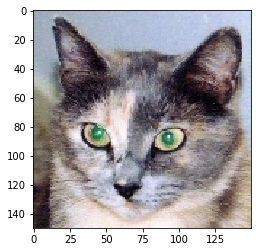

In [15]:
plt.imshow(img_tensor[0])
plt.show()

In [16]:
layer_outputs = [layer.output for layer in model.layers[:8]] # Extract the outputs from top 8 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

### Running the model in predict mode

In [17]:
activations = activation_model.predict(img_tensor)

In [21]:
first_layer_activation = activations[0]
second_layer_activation = activations[1]
print("First Layer:", first_layer_activation.shape)
print("second Layer:", second_layer_activation.shape)

First Layer: (1, 148, 148, 32)
second Layer: (1, 74, 74, 32)


### Visualize the fourth channel

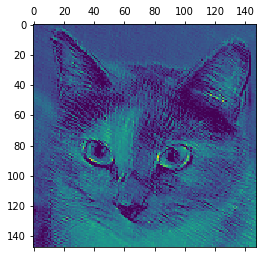

In [29]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

### Visualizing every channel in every intermediate activation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


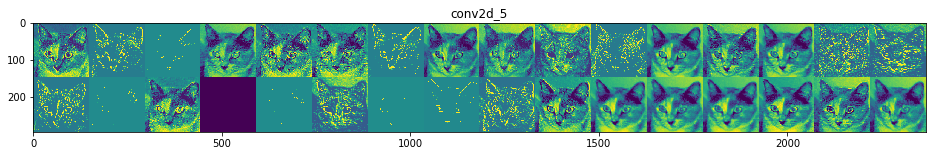

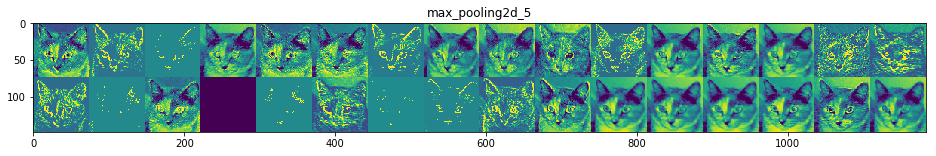

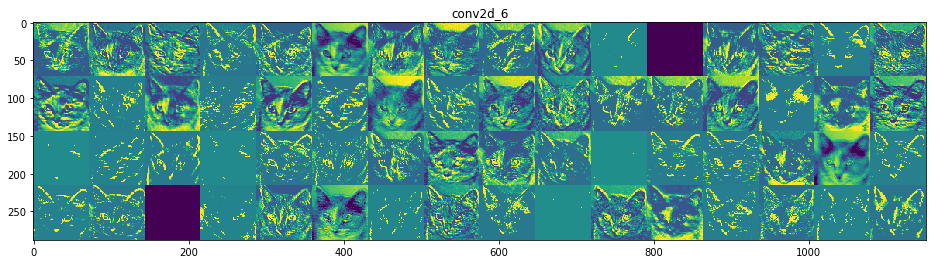

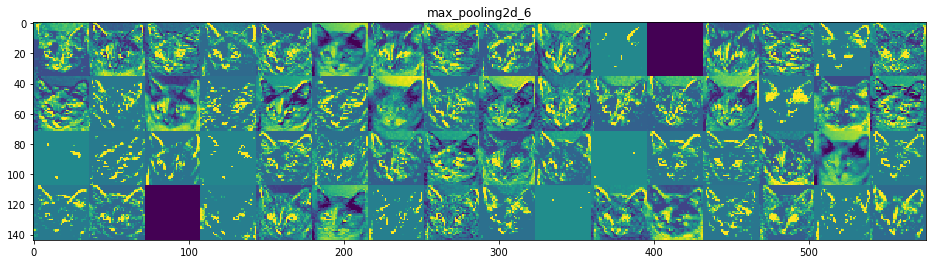

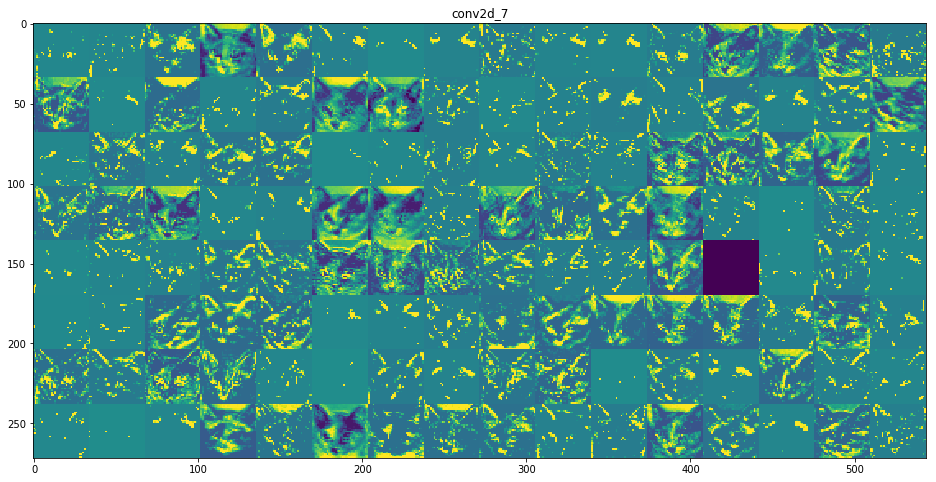

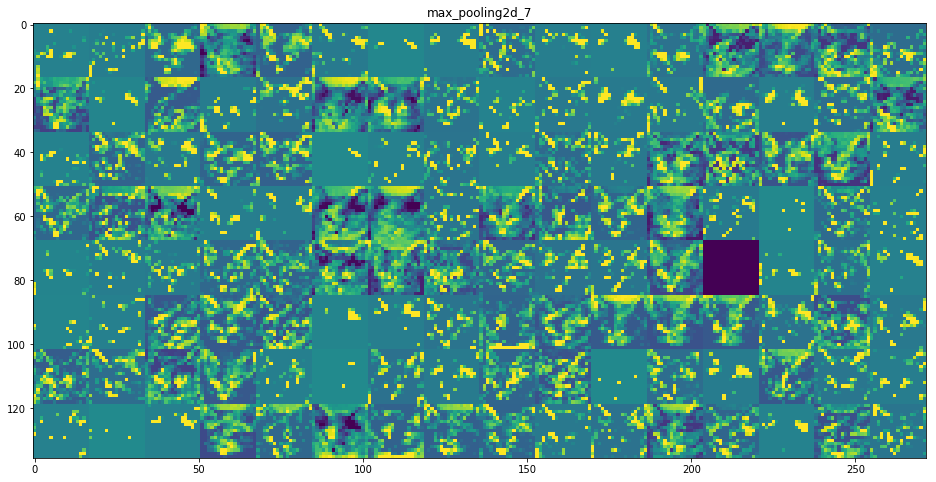

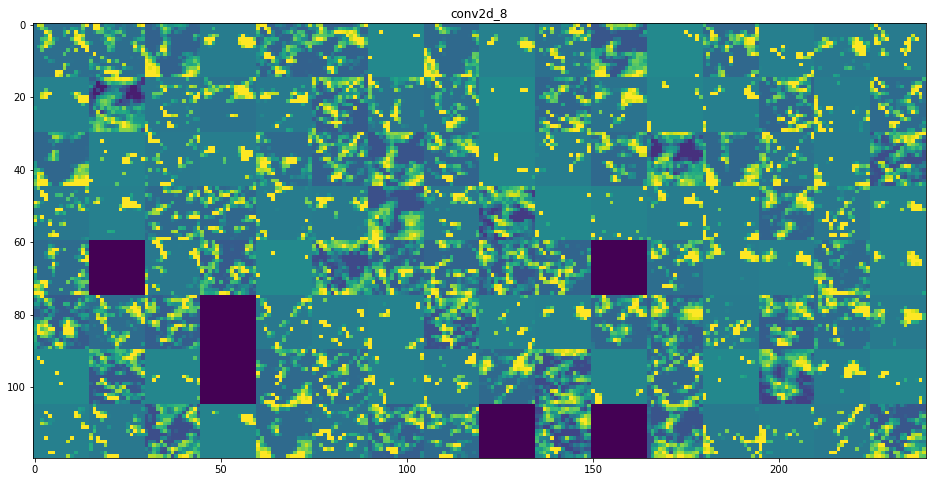

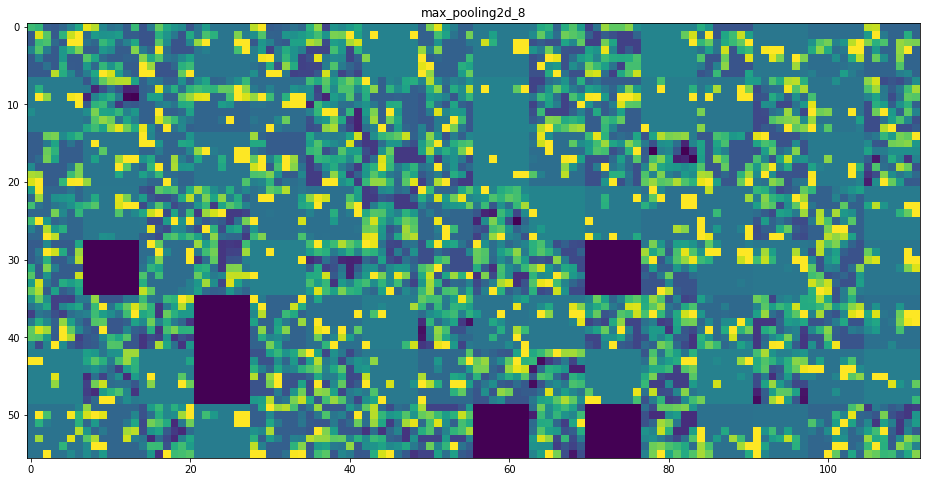

In [31]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,row * size : 
                     (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### There are a few things to note here:
- The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
- As you go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
- The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

Universal characteristic of the representations learned by deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer. The activations of higher layers carry less and less information about the specific input being seen, and more and more information about the target (in this case, the class of the image: cat or dog). A deep neural network effectively acts as an information distillation pipeline, with raw data going in (in this case, RGB pictures) and being repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and
useful information is magnified and refined (for example, the class of the image).